In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline

warnings.simplefilter('ignore')

In [146]:
antenna_poplulation = 5
tag_population = 1
y_distance = np.sqrt((3.16) ** 2 + (0.78) ** 2)
sample_count = 150
frequency_mhz = 918.0
frequency = frequency_mhz * (10 ** 6)
antenna_space = 0.25
transmission_power = 30.0
light_speed = 2.998e8
wave_length = light_speed / frequency
angular_velocity = 2 * np.pi * frequency
T = 1 / frequency
theta_range = np.arange(-60, 60.001, 0.001)
antenna_gain_dbi = 8.5
tx_power_dbm = 37.5
antenna_gain_watt = 10 ** ((antenna_gain_dbi - 30) / 10)
tx_power_watt = 10 ** ((tx_power_dbm - 30) / 10)

In [147]:
TARGET_TAG = "E200 4216 0370 6410 02BC E12B"
DATA_FILE_PATH = "data/aoa_150.csv"

actual_angle = np.arctan(float(DATA_FILE_PATH.split("_")[1].split(".")[0]) / 100 / y_distance) * 180 / np.pi
print(actual_angle)

24.742697599787533


In [148]:
df = pd.read_csv(DATA_FILE_PATH)
df = df[df["tagId"] == TARGET_TAG]
df = df[df["frequency"] == frequency_mhz]
# df = df.query(f"samplingNumber < {sample_count * 6}")
df["distance"] = wave_length / (4 * np.pi) * (((antenna_gain_watt ** 3) * tx_power_watt / (10 ** ((df["rssi"] - 30) / 10))) ** (1/4))
df = df[["antennaNumber", "phase", "samplingNumber", "timestamp", "distance", "rssi"]]
df.tail(18)

,antennaNumber,phase,samplingNumber,timestamp,distance,rssi
3094,5,1.098330,3094,1717489758557728,0.189356,-61.5
3097,5,1.092194,3097,1717489758635845,0.189356,-61.5
3099,1,2.264156,3099,1717489758716787,0.168764,-59.5
3101,1,5.424156,3101,1717489758779534,0.168764,-59.5
3104,2,3.896311,3104,1717489758895437,0.173692,-60.0
3106,2,0.742447,3106,1717489758952897,0.173692,-60.0
3109,3,1.245592,3109,1717489759054415,0.168764,-59.5
3111,3,1.251728,3111,1717489759114236,0.168764,-59.5
3114,4,5.283030,3114,1717489759221320,0.200576,-62.5
3115,4,5.313709,3115,1717489759247225,0.200576,-62.5


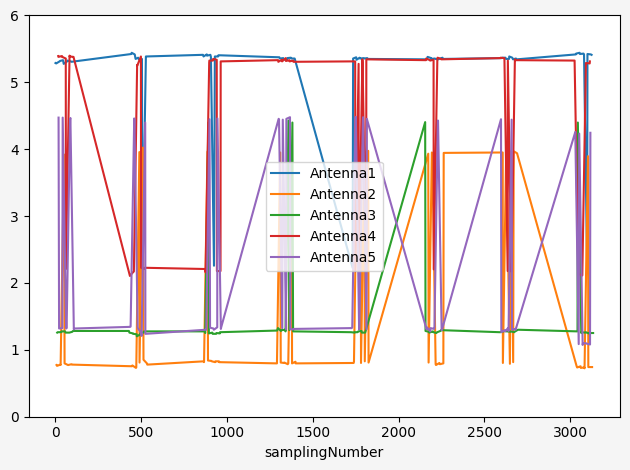

In [149]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
for antenna in range(1, antenna_poplulation+1):
    df[df["antennaNumber"] == antenna].plot(ax=ax, x="samplingNumber", y="phase", )
ax.set_yticks(np.arange(0, 7, 1))
plt.legend([f"Antenna{antenna}" for antenna in range(1, antenna_poplulation+1)])
plt.show()

In [150]:
data_list = []
for i in range(int(sample_count)):
    df2 = df.query(f"{6*i} <= samplingNumber < {6 * (i+1)}")
    df2_even = df2[df["samplingNumber"] % 2 == 0]
    df2_odd = df2[df["samplingNumber"] % 2 == 1]
    data_even = df2_even["phase"].to_numpy()
    data_odd = df2_odd["phase"].to_numpy()
    data_list.append([data_even])
    data_list.append([data_odd])
data_list = np.array(data_list)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (300, 1) + inhomogeneous part.

In [ ]:
from classes.music import MUSIC

transmit_wave = np.full(
    (sample_count * 2, antenna_poplulation, tag_population), transmission_power
)

music = MUSIC(antenna_poplulation=antenna_poplulation, tag_population=tag_population, frequency=frequency, sampling_count=sample_count, antenna_space=antenna_space, tx_power=transmission_power, theta_range=theta_range)
music_spectrum = music.get_music_spectrum(phase_data_list=data_list, transmission_wave_data_list=transmit_wave)
estimated_angles = music.peak_search(music_spectrum=music_spectrum)
print(estimated_angles)

[-45.59   -3.606  36.055]


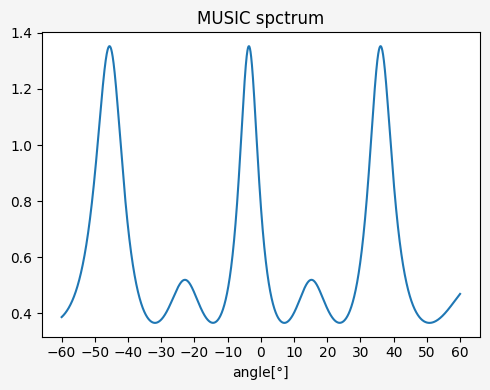

In [ ]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=5, h=4)
x = theta_range
ax.plot(x, music_spectrum)
ax.set_xticks(np.arange(-60, 61, step=10))
ax.set_title("MUSIC spctrum")
ax.set_xlabel("angle[°]")
plt.show()